# Control Experiment: Context Only

This control tests predicting logP directly from pooled molecular features **without per-atom scalars**. Uses MPNN embeddings but predicts a single molecular logP value.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader

from src.mlp_regressor.mlp import ContextOnlyMLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Data Loading

Load MPNN-processed atom embeddings from cache.

In [2]:
import pickle

DATA_DIR = Path('../data')
CACHE_FILE = DATA_DIR / 'cache' / 'processed_molecules_cache.pkl'
SPLITS_DIR = DATA_DIR / 'splits'

# Load cached MPNN embeddings
with open(CACHE_FILE, 'rb') as f:
    cache = pickle.load(f)

X_atoms = cache['X_atom_fps']
atom_contribs = cache['atom_rdkit_score']
mol_indexs = cache['mol_indexs']
mol_data = cache['mol_data']

print(f'MPNN embedding dim: {X_atoms.shape[1]}')
print(f'Total atoms: {len(X_atoms)}, Total molecules: {len(mol_data)}')

MPNN embedding dim: 40
Total atoms: 238271, Total molecules: 13961


In [3]:
# Load splits
train_df = pd.read_csv(SPLITS_DIR / 'train.csv')
val_df = pd.read_csv(SPLITS_DIR / 'val.csv')
test_df = pd.read_csv(SPLITS_DIR / 'test.csv')

train_mol_indices = train_df['mol_index'].values
val_mol_indices = val_df['mol_index'].values
test_mol_indices = test_df['mol_index'].values

print(f'Train: {len(train_mol_indices)}, Val: {len(val_mol_indices)}, Test: {len(test_mol_indices)}')

Train: 10051, Val: 1117, Test: 2793


In [4]:
class ContextOnlyDataset(Dataset):
    """Dataset that returns mean-pooled molecular features."""
    def __init__(self, X_atoms, mol_indexs, mol_data, mol_index_list):
        self.X_atoms = X_atoms
        self.mol_indexs = mol_indexs
        self.mol_data = mol_data
        self.mol_index_list = mol_index_list

    def __len__(self):
        return len(self.mol_index_list)

    def __getitem__(self, idx):
        mol_index = self.mol_index_list[idx]
        atom_mask = self.mol_indexs == mol_index
        atom_features = torch.FloatTensor(self.X_atoms[atom_mask])
        
        return {
            'atom_features': atom_features,
            'exp_logp': torch.FloatTensor([self.mol_data[mol_index]['exp_logp']]),
            'rdkit_logp': torch.FloatTensor([self.mol_data[mol_index]['rdkit_logp']]),
            'mw': self.mol_data[mol_index]['mw'],
            'mol_index': mol_index
        }


def collate_fn(batch):
    return batch

In [5]:
BATCH_SIZE = 32

train_dataset = ContextOnlyDataset(X_atoms, mol_indexs, mol_data, train_mol_indices)
val_dataset = ContextOnlyDataset(X_atoms, mol_indexs, mol_data, val_mol_indices)
test_dataset = ContextOnlyDataset(X_atoms, mol_indexs, mol_data, test_mol_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## Model

In [6]:
INPUT_DIM = X_atoms.shape[1]  # MPNN embeddings (44)
HIDDEN_LAYERS = [40, 40, 32]
LEARNING_RATE = 0.001

model = ContextOnlyMLP(input_dim=INPUT_DIM, hidden_dims=HIDDEN_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

ContextOnlyMLP(
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=40, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 4,625


## Training

In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training', leave=False):
        for mol in batch:
            atom_features = mol['atom_features'].to(device)
            exp_logp = mol['exp_logp'].to(device)
            
            optimizer.zero_grad()
            pred_logp = model(atom_features)
            loss = criterion(pred_logp.unsqueeze(0), exp_logp)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return total_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    preds, targets, baselines, mws, mol_indices = [], [], [], [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            for mol in batch:
                atom_features = mol['atom_features'].to(device)
                pred_logp = model(atom_features).item()
                
                preds.append(pred_logp)
                targets.append(mol['exp_logp'].item())
                baselines.append(mol['rdkit_logp'].item())
                mws.append(mol['mw'])
                mol_indices.append(mol['mol_index'])
    return np.array(preds), np.array(targets), np.array(baselines), np.array(mws), np.array(mol_indices)

In [8]:
NUM_EPOCHS = 50
PATIENCE = 10

best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_preds, val_targets, _, _, _ = evaluate(model, val_loader, device)
    val_loss = mean_squared_error(val_targets, val_preds)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'context_only_best.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val MSE = {val_loss:.4f}')
    
    if patience_counter >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1}')
        break

model.load_state_dict(torch.load('context_only_best.pt'))

Epoch 5: Train Loss = 1.5613, Val MSE = 1.4654


Epoch 10: Train Loss = 1.4641, Val MSE = 1.6334


Epoch 15: Train Loss = 1.4166, Val MSE = 1.1934


Epoch 20: Train Loss = 1.3677, Val MSE = 1.2375


Epoch 25: Train Loss = 1.3610, Val MSE = 1.0844


Epoch 30: Train Loss = 1.3795, Val MSE = 1.2572


Epoch 35: Train Loss = 1.2995, Val MSE = 1.3424


Epoch 40: Train Loss = 1.2902, Val MSE = 1.1454


Early stopping at epoch 44


<All keys matched successfully>

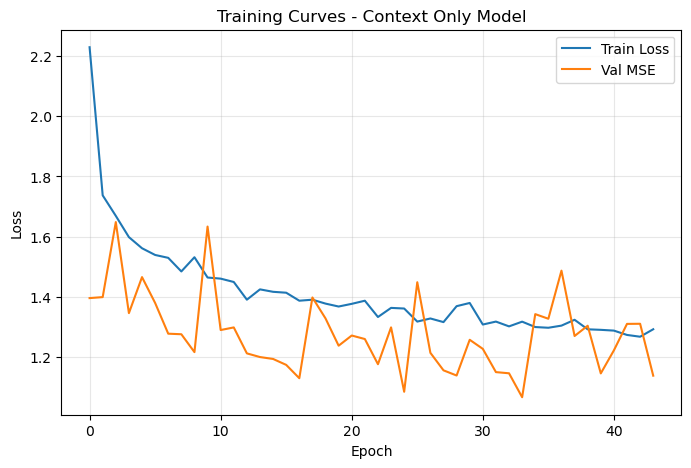

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Val MSE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curves - Context Only Model')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Evaluation

In [10]:
test_preds, test_targets, test_baselines, test_mws, test_mol_indices = evaluate(model, test_loader, device)

rmse_baseline = np.sqrt(mean_squared_error(test_targets, test_baselines))
mae_baseline = mean_absolute_error(test_targets, test_baselines)
rmse_model = np.sqrt(mean_squared_error(test_targets, test_preds))
mae_model = mean_absolute_error(test_targets, test_preds)

print('Test Set Performance')
print('=' * 50)
print(f'{"Metric":<20} | {"Wildman-Crippen":<15} | {"Context Only":<15}')
print('-' * 50)
print(f'{"RMSE":<20} | {rmse_baseline:<15.4f} | {rmse_model:<15.4f}')
print(f'{"MAE":<20} | {mae_baseline:<15.4f} | {mae_model:<15.4f}')

Test Set Performance
Metric               | Wildman-Crippen | Context Only   
--------------------------------------------------
RMSE                 | 2.0893          | 1.0553         
MAE                  | 1.7294          | 0.7911         


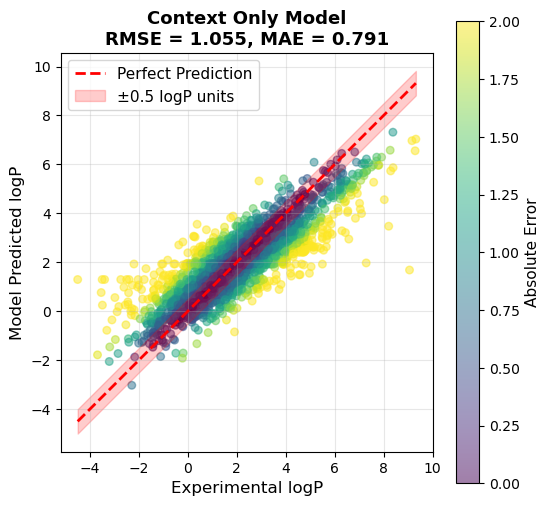

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

scatter = ax.scatter(test_targets, test_preds, alpha=0.5, s=30, 
                     c=np.abs(test_targets - test_preds), cmap='viridis', vmin=0, vmax=2)

min_val = min(test_targets.min(), test_preds.min())
max_val = max(test_targets.max(), test_preds.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.fill_between([min_val, max_val], [min_val - 0.5, max_val - 0.5], 
                [min_val + 0.5, max_val + 0.5], alpha=0.2, color='red', label='±0.5 logP units')

ax.set_xlabel('Experimental logP', fontsize=12)
ax.set_ylabel('Model Predicted logP', fontsize=12)
ax.set_title(f'Context Only Model\nRMSE = {rmse_model:.3f}, MAE = {mae_model:.3f}', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=11)
plt.show()

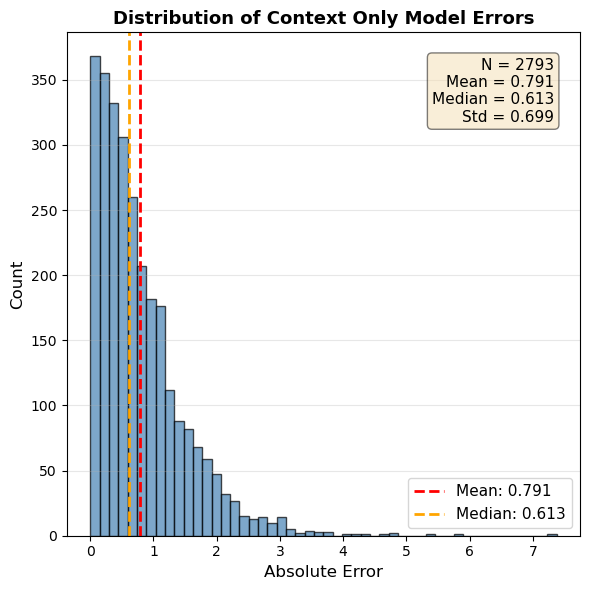

In [12]:
model_abs_errors = np.abs(test_preds - test_targets)

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(model_abs_errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')

mean_error = np.mean(model_abs_errors)
median_error = np.median(model_abs_errors)
ax.axvline(mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_error:.3f}')
ax.axvline(median_error, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_error:.3f}')

ax.set_xlabel('Absolute Error', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Context Only Model Errors', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

stats_text = f'N = {len(model_abs_errors)}\n'
stats_text += f'Mean = {mean_error:.3f}\n'
stats_text += f'Median = {median_error:.3f}\n'
stats_text += f'Std = {np.std(model_abs_errors):.3f}'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Summary

The context-only model predicts logP directly from mean-pooled MPNN embeddings:
- Uses message passing (molecular structure encoded)
- No per-atom scalars (single molecular prediction)

Compare with the full model to quantify the contribution of per-atom correction factors.